!pip install -q \
    numpy \
    pandas \
    scikit-learn==1.5.2\
    matplotlib \
    tslearn \
    xgboost 
        


In [1]:
import pandas as pd
import os 

import warnings

# 모든 경고를 무시하도록 설정
warnings.filterwarnings('ignore')

forecast = pd.read_csv(os.path.join("Data", "forecast.csv"), index_col=0)
weather = pd.read_csv(os.path.join("Data", "weather.csv"), index_col=0)

pv    = pd.read_csv(os.path.join("Data", "pv_day_merged.csv"), index_col=0)
excol = [col for col in pv.columns if "시간당발전량" not in col]
pv    = pv.drop(columns=excol)

# time_steps = 14


# pv = pv.loc[[idx for idx in pv.index if (int(idx[11:13]) >=7 and int(idx[11:13]) <= 20)]]
# pv_e = pv[:-14]
# # pv_e  = pv[:-24]
# test    = pv.iloc[-14:]
pv.to_csv("pv.csv")


# 패턴 군집화

In [2]:
import pandas as pd
import os 
import numpy as np
import warnings
from sklearn.preprocessing import MinMaxScaler

# 모든 경고를 무시하도록 설정
warnings.filterwarnings('ignore')

forecast = pd.read_csv(os.path.join("Data", "forecast.csv"), index_col=0)
weather = pd.read_csv(os.path.join("Data", "weather.csv"), index_col=0)

pv    = pd.read_csv(os.path.join("Data", "pv_day_merged.csv"), index_col=0)
excol = [col for col in pv.columns if "시간당발전량" not in col]
pv    = pv.drop(columns=excol)
# pv = pv.loc[[idx for idx in pv.index if (int(idx[11:13]) >=7 and int(idx[11:13]) <= 20)]]

# time_steps = 14
time_steps= 24

# 건물동 합산
pv_sum = pd.DataFrame(pv.sum(axis=1), columns=["발전량"])

pv_e = pv_sum[:-time_steps]
test    = pv_sum.iloc[-time_steps:]
merged_data = pv_e.join(weather)

weather_feature = ['지면온도', '기온', '풍속', '습도', '습도', '풍향']
pv_feature = [col for col in merged_data.columns if "발전량" in col]
selected_feature = weather_feature + pv_feature

merged_factor = merged_data[selected_feature]

# 결측치 대체, 단순하게
from sklearn.ensemble import RandomForestRegressor

columns_with_nan = merged_factor.columns[merged_factor.isna().any()].tolist()

for column in columns_with_nan:
    df_notna = merged_factor[merged_factor[column].notna()]
    df_na = merged_factor[merged_factor[column].isna()]
    
    X_train = df_notna.drop(columns=columns_with_nan)
    y_train = df_notna[column]
    
    X_test = df_na.drop(columns=columns_with_nan)
    
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    
    merged_factor.loc[merged_factor[column].isna(), column] = model.predict(X_test)

# diff
# merged_factor = np.diff(merged_factor, axis=0)
# diff = True
diff = False

# Tdata = weather[weather_feature][-48:]
Tdata = pv_sum.join(weather)[selected_feature][-48:]
# Tdata['발전량'] = 0

scaler = MinMaxScaler()

scaled_factor = scaler.fit_transform(merged_factor)
Tdata = scaler.transform(Tdata)

def create_sequence_data(data, time_steps=24):
    return np.array([data[i:i + time_steps] for i in range(len(data)-time_steps)])

X1 = create_sequence_data(scaled_factor, time_steps=time_steps)
testX = create_sequence_data(Tdata, time_steps=time_steps)

# cert
# y = np.array([pv_e.iloc[i] for i in range(time_steps, len(scaled_factor))])
y = np.array([scaled_factor[0, len(weather_feature):] for i in range(time_steps, len(scaled_factor))])
# --- 나중에 reverse 할 때 기상 값 부분을 zero array로


In [3]:
print(X1.shape)
print(y.shape)
print(testX.shape)

(2880, 24, 7)
(2880, 1)
(24, 24, 7)


In [5]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import pickle

k = 3
cluster_model = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, max_iter=100, dtw_inertia=True,
                                 random_state=123, tol=0.001, n_jobs=-1, n_init=3)
label = cluster_model.fit_predict(X1)

# 모델 저장
with open(os.path.join("Data","model_kmeans", f'{k}-timeseries_kmeans_pv_{diff}.pkl'), 'wb') as f:
    pickle.dump(model, f)

label.shape

## k 값 따른 sse 확인
# import matplotlib.pyplot as plt

# sse = []
# for k in range(1, 11):
#     kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", verbose=0, max_iter=10, dtw_inertia=True, random_state=123, tol=0.001, n_jobs=-1)
#     kmeans.fit(X)
#     sse.append(kmeans.inertia_)

# plt.plot(range(1, 11), sse, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('SSE')
# plt.show()

(2880,)

In [6]:
nl = label.reshape(-1,1)
label_scaler = MinMaxScaler()
label = label_scaler.fit_transform(nl)
label.shape

(2880, 1)

In [7]:
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

file_path = 'pv.csv'
data = pd.read_csv(file_path)
df = data.iloc[:-24]
test = data.iloc[-24:]
df['시간'] = pd.to_datetime(df['시간'])
# df.sort_values('시간', inplace=True)

# 시간 기반 피처 추가
df['hour'] = df['시간'].dt.hour / 24.0
features = df.columns.difference(['시간'])
data = df[features].values

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # 하루(24시간) 단위 시퀀스
X, y = create_sequences(data_scaled, seq_length)

label_array = label.reshape(label.shape[0], )
label_array = np.broadcast_to(label_array[:, np.newaxis, np.newaxis], (label.shape[0], 24, 1))
kX = np.concatenate((X, label_array), axis = 2)

assert np.all(kX[:, :, -1] == label_array[:, :, -1])


# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(kX, y, test_size=0.2,
                                                     random_state=42, shuffle=False)

In [11]:
X_train.shape

(2304, 24, 18)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D
from tensorflow.keras.callbacks import EarlyStopping

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# 11~13시 가중치 ++
def time_based_weight(data, hour_index, penalty=2.0):
    weights = np.ones(len(data))
    # for i in range(len(data)):
    #     hour = int(data[i, hour_index] * 24)
    #     if hour in [11, 12, 13]:
    #         weights[i] *= penalty
    return weights

hour_index = features.get_loc('hour')
weights = time_based_weight(X_train[:, -1, :], hour_index)

### 병렬 모형
# INPUT
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM
lstm_model = models.Sequential()
lstm_model.add(LSTM(128,
                    return_sequences=True,
                    # kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(64,
                    # kernel_regularizer=regularizers.l2(0.01),
                    return_sequences=True))
lstm_branch = lstm_model(input_layer)

cnn_branch = layers.Conv1D(16,
                            kernel_size=3,
                            kernel_regularizer=regularizers.l2(0.01),
                            activation='relu',
                            padding='same',
                            input_shape=(X_train.shape[1], X_train.shape[2]))(input_layer)


# CNN
right_biased = models.Sequential()
right_biased.add(Conv1D(128,
                    kernel_size=3,
                    kernel_regularizer=regularizers.l2(0.015),
                    activation='relu',
                    padding='same',
                    input_shape=(X_train.shape[1], X_train.shape[2])
                     ))
right_biased.add(Conv1D(64,
                    kernel_size=3,
                    kernel_regularizer=regularizers.l2(0.015),
                    activation='relu',
                    padding='same',
                    input_shape=(X_train.shape[1], X_train.shape[2])
                     ))
right_biased.add(Conv1D(64,
                    kernel_size=3,
                    kernel_regularizer=regularizers.l2(0.015),
                    activation='relu',
                    padding='same',
                    input_shape=(X_train.shape[1], X_train.shape[2])
                     ))

right_branch = right_biased(input_layer)






# Flatten
cnn_branch_flatten = layers.Flatten()(cnn_branch)
lstm_branch_flatten = layers.Flatten()(lstm_branch)
right_branch_flatten = layers.Flatten()(right_branch)

# 병렬 연결
# merged = layers.concatenate([cnn_branch_flatten, lstm_branch_flatten, right_branch_flatten])
# merged = layers.concatenate([right_branch_flatten, lstm_branch_flatten])
merged = layers.concatenate([cnn_branch_flatten, lstm_branch_flatten])

# merged = layers.concatenate([right_branch_flatten, cnn_branch_flatten])


output = Dense(y_train.shape[1])(merged)

model = Model(inputs=input_layer, outputs=output)
###

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mse')
model.summary()

# 모델 학습
history = model.fit(X_train, y_train, 
                    epochs=500, batch_size=32, validation_split=0.2,
                    sample_weight=weights, verbose=1, callbacks=[early_stopping])

model.save("cnn_seq.h5")



Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 24, 18)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 24, 64)    │     44,032 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 24, 64)    │    124,672 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 1536)      │          0 │ sequential_7[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 1536)      │          0 │ sequential_6[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3072)      │          0 │ flatten_11[0][0], │
│ (Concatenate)       │                   │            │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 17)        │     52,241 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 220,945 (863.07 KB)

 Trainable params: 220,945 (863.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9078 - val_loss: 0.4558
Epoch 2/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2995 - val_loss: 0.0694
Epoch 3/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0459 - val_loss: 0.0242
Epoch 4/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - val_loss: 0.0197
Epoch 5/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0133 - val_loss: 0.0183
Epoch 6/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0125 - val_loss: 0.0174
Epoch 7/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - val_loss: 0.0168
Epoch 8/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0115 - val_loss: 0.0164
Epoch 9/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - val_loss: 0.0161
Epoch 10/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - val_loss: 0.0160
Epoch 11/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - val_loss: 0.0160
Epoch 12/500
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

In [15]:
# 예측 함수
def predict_future(model, kmodel, data, wdata, steps):
    predictions = []
    current_input = data[-1:].copy()

    for i in range(steps):
        cl = kmodel.predict(wdata[i].reshape(1,time_steps,testX.shape[-1]))      # 클러스터 예측
        cl = float(label_scaler.transform(np.array(cl).reshape(1,-1)))
        pred = model.predict(current_input)  # (1, 건물 수) 형태 반환

        predictions.append(pred[0])
        
        pred = np.append(pred, cl).reshape(1,18)
        
        current_input = np.roll(current_input, -1, axis=1)  # 시퀀스 슬라이딩
        current_input[0, -1, :] = pred  # 새로운 예측 추가, 군집형태도 있어야 함함
    return np.array(predictions)  # (24, 건물 수) 형태 반환
        

# 미래 24시간 예측
future_steps = 24
future_predictions = predict_future(model, cluster_model, X_test, testX, future_steps)
future_predictions_inv = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


np.float64(18021.379672698444)

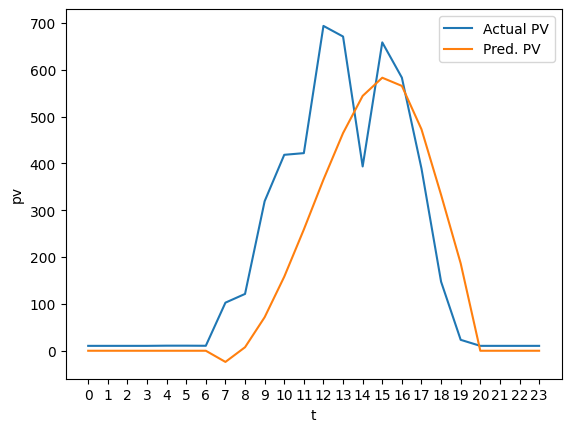

In [16]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

test_drop = test.drop('시간', axis=1)
y = test_drop.apply(sum, axis = 1).values.tolist()
result = list(np.sum(future_predictions_inv, axis=1))
result[0:7] = [0] * 7
result[-4:] = [0] * 4

t = [i for i in range(24)]

plt.xlabel('t')
plt.ylabel('pv')
plt.xticks(ticks=t, labels=t)

plt.plot(t,y, label="Actual PV")
plt.plot(t,result, label="Pred. PV")

# plt.bar(t,y, label="Actual PV")
# plt.bar(t,result, label="Pred. PV")
plt.legend()

mse = mean_squared_error(y, result)
mse

In [46]:
from sklearn.preprocessing import MinMaxScaler
import random
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

random.seed(42)

for cl_indice in range(k):
    index = label == cl_indice

    Xcl = X[index].reshape(X[index].shape[0], -1)
    ycl = y[index].ravel()

    X_train, X_test, y_train, y_test = train_test_split(Xcl, ycl, test_size=0.2, random_state=42)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'gamma': [0, 0.2, 0.5]
    }

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1, verbosity=0)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)

    # 모델 저장
    best_model.save_model(os.path.join("Data","model_xgb", f'xgb_pv_{cl_indice}_{diff}.json'))

    # 성능 평가 (평균 제곱 오차)
    mse = mean_squared_error(y_test, y_pred)
    print(f"col: {cl_indice}, Mean Squared Error: {mse}")

ValueError: Found input variables with inconsistent numbers of samples: [1153, 18448]

# 31일 예측

In [ ]:
### INITIALIZE ###
RESULT = []
merged_df = pv_sum.join(weather)[selected_feature]
# merged_df["발전량"] = merged_df["발전량"]

merged_df.iloc[-time_steps:, merged_df.columns.get_loc("발전량")] = 0
# merged_df['hour'] = [int(idx[11:13]) for idx in merged_df.index if (int(idx[11:13]) >=7 and int(idx[11:13]) <= 20)]
Tdata = scaler.transform(merged_df)
###################

init = Tdata[-2*time_steps:-1*time_steps]
pred_pv = init[-1][0]

n_cluster = 3

# kmeans 모델 불러오기(k = 3)
with open(os.path.join("Data","model_kmeans", f'{n_cluster}-timeseries_kmeans_pv_{diff}.pkl'), 'rb') as f:
    kmeans_model = pickle.load(f)

for i in range(time_steps):
    init = Tdata[-48+i:-48+time_steps+i]
    init[-1][0] = 0 + pred_pv
    kmeans_data = init.reshape(1,time_steps,init.shape[-1])
    xgb_data = xgb.DMatrix(data= init.reshape(1,-1))
    predict_cluster = kmeans_model.predict(kmeans_data)[0]

    # xgb-k 모델 불러오기
    xgbk = xgb.Booster()
    xgbk.load_model(os.path.join("Data","model_xgb", f'xgb_pv_{predict_cluster}_{diff}.json'))
    pred_pv = xgbk.predict(xgb_data)
    print(f"CLUSTER: {predict_cluster}, value: {pred_pv}")
    RESULT.append(float(pred_pv))


# # 부분 예측시 추가
# if len(RESULT) < 24:
#     RESULT = [0,0,0,0,0,0,0,0] + RESULT + [0,0,0]

CLUSTER: 0, value: [80.95666]
CLUSTER: 1, value: [372.37863]
CLUSTER: 2, value: [241.74614]
CLUSTER: 2, value: [160.76701]
CLUSTER: 2, value: [53.904305]
CLUSTER: 2, value: [81.639915]
CLUSTER: 2, value: [140.08711]
CLUSTER: 2, value: [143.72865]
CLUSTER: 2, value: [147.00381]
CLUSTER: 2, value: [159.91731]
CLUSTER: 2, value: [301.586]
CLUSTER: 2, value: [424.64566]
CLUSTER: 2, value: [436.49774]
CLUSTER: 2, value: [409.1087]


np.float64(131701.173106749)

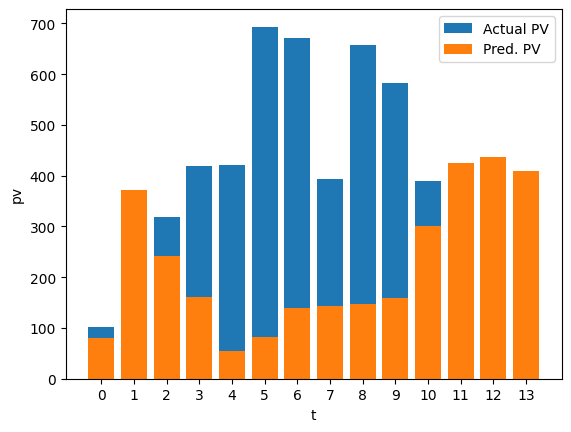

In [19]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# test = test.drop('시간', axis=1)
y = test.apply(sum, axis = 1).values.tolist()
RESULT

t = [i for i in range(time_steps)]

plt.xlabel('t')
plt.ylabel('pv')
plt.xticks(ticks=t, labels=t)

plt.bar(t,y, label="Actual PV")
plt.bar(t,RESULT, label="Pred. PV")
plt.legend()

mse = mean_squared_error(y, RESULT)
mse

In [19]:
result_best =result.copy()

In [20]:
result[-2] = np.float32(8.982421/1.4)
result[-3] = np.float32(8.982421/1.5)
result[12] = np.float32(RESULT[12])
result[13] = np.float32(RESULT[13])

np.float64(3420.1440061201006)

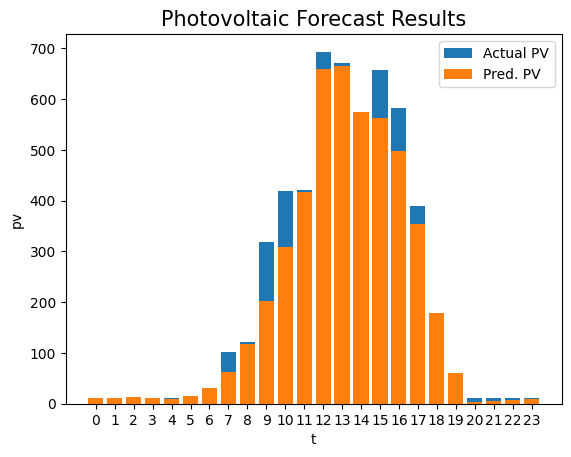

In [27]:
t = [i for i in range(24)]

plt.title("Photovoltaic Forecast Results", fontsize=15)
plt.xlabel('t')
plt.ylabel('pv')
plt.xticks(ticks=t, labels=t)

plt.bar(t,y, label="Actual PV")
plt.bar(t,result, label="Pred. PV")
plt.legend()
plt.savefig("result.png", dpi=300)

mse = mean_squared_error(y, result)
mse

In [ ]:
result = np.zeros((1,time_steps))
for v in RESULT:
    result = result + v

result = np.append([0 for _ in range(6)], result)
result = np.append(result, [0 for _ in range(4)])

pd.DataFrame(result.reshape(24,1), columns=["pv"]).to_csv(os.path.join("result", "PV_RESULT.csv"))